In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet/" ./

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

<ipython-input-2-255f4ac980e9>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [5]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    #cmax = np.clip(c * 1.2, 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

slack_blue  = get_alpha_cmap((63, 81, 181))
slack_green = get_alpha_cmap((76, 175, 80) )
slack_red   = get_alpha_cmap((210, 40, 95))

slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

brown = get_alpha_cmap((121, 85, 72))
dark_brown = get_alpha_cmap((109, 76, 65))

In [6]:
baseline_to_color = {
'zero' : anthracite,
'uniform' : slack_violet,
'normal' : slack_violet,
'permutation' : google_yellow,
'local_permutation' : google_yellow,
'local_mean' : google_blue,
'mean' : google_blue,
'median' : google_blue,
'random_color' : anthracite,
'scramble_phase' : slack_red,
'scramble_amplitude' : slack_red,
}

baseline_to_linestyle = {
'zero' : '-',
'uniform' : '-',
'normal' : '--',
'permutation' : '-',
'local_permutation' : '--',
'local_mean' : '-',
'mean' : '--',
'median' : ':',
'random_color' : '--', # pas de coup de pute Legolas !
'scramble_phase' : '-',
'scramble_amplitude' : '--',
}

In [14]:
data = np.load('/content/results_resnet/removal_scores_resnet.npy', allow_pickle=True)[()]
data.keys()

dict_keys(['zero', 'uniform', 'normal', 'permutation', 'local_mean', 'local_permutation', 'mean', 'median', 'random_color', 'scramble_phase', 'scramble_amplitude'])

In [16]:
data['zero']

[(0, 239592.02),
 (1, 238372.69),
 (2, 237982.34),
 (3, 237726.66),
 (4, 237583.95),
 (5, 237713.97),
 (6, 237888.1),
 (7, 237933.94),
 (8, 238241.62),
 (9, 238807.08),
 (10, 239113.72),
 (11, 239457.39),
 (12, 239729.89),
 (13, 239933.83),
 (14, 239944.11),
 (15, 239887.6),
 (16, 239914.48),
 (17, 240039.38),
 (18, 240128.03),
 (19, 240305.4)]

In [8]:
for baseline in data.keys():
  print(baseline)

zero
uniform
normal
permutation
local_mean
local_permutation
mean
median
random_color
scramble_phase
scramble_amplitude


In [20]:
results = {}

for baseline in data.keys():
  removal_curve = [s/1000/1000 for _,s in data[baseline]]
  results[baseline] = removal_curve

In [10]:
!pip install -q csaps

In [18]:
from scipy.interpolate import interp1d
import csaps

def poly_interp(points, smooth = 0.85, nb_points = 300):
  #polynom = np.polyfit(range(len(points)), points, order)
  xs = np.linspace(0, len(points)-1, nb_points)
  #f = scipy.interpolate.spline(xk, yk, xnew, order=3, kind='smoothest', conds=None)
  #f = interp1d(range(len(points)), points, kind='quadratic')
  #f = csaps.UnivariateCubicSmoothingSpline(range(len(points)), points, smooth=0.85)
  #ys = f(xs)
  ys = csaps.csaps(range(len(points)), points, xs, smooth=smooth)
  #ys = np.polyval(polynom, xs)

  return xs, ys

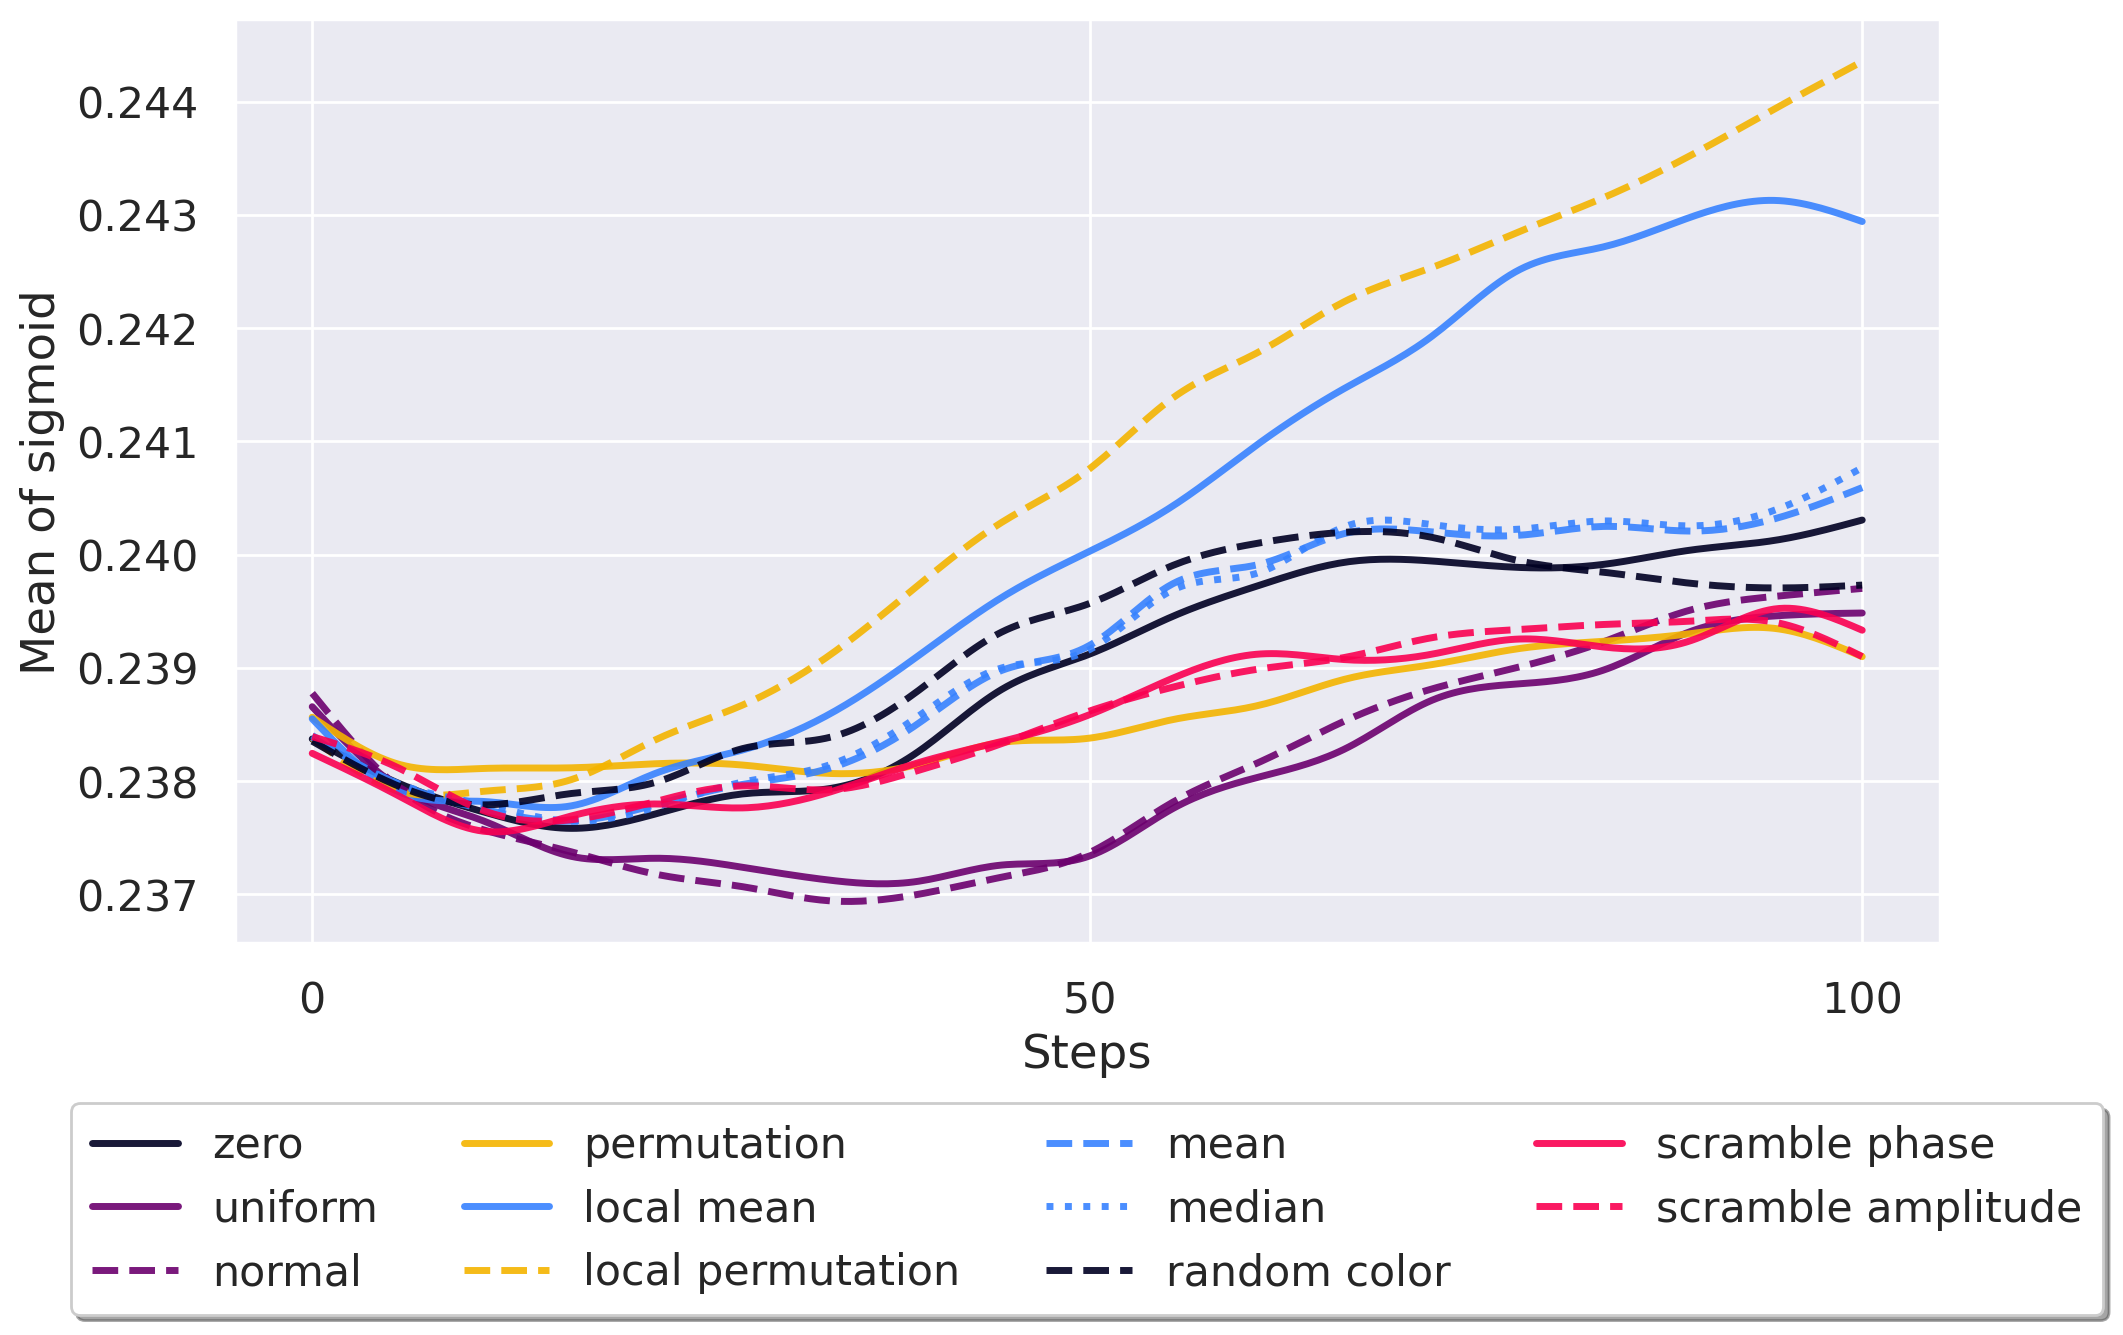

In [22]:
sns.set(font_scale=1.4)
set_size(11, 6)
cmap = plt.get_cmap('viridis')

lw = 2.5

for baseline in results:
  points = results[baseline]

  curve = [np.mean(p) for p in points][1:]
  stds = [np.std(p) for p in points][1:]

  color = baseline_to_color[baseline]
  ls = baseline_to_linestyle[baseline]

  xs, ys = poly_interp(curve, smooth=1.0)

  #plt.plot(curve, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)
  plt.plot(xs, ys, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.9, linestyle=ls)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                      facecolor='white')
plt.xticks([0, xs[len(xs)//2], xs[-1]], [0, 50, 100])
plt.xlabel("Steps")
plt.ylabel('Mean of sigmoid')
plt.savefig('removal_resnet.png', dpi=400, transparent=True)
#plt.title()

In [ ]:
sns.set(font_scale=0.7)
set_size(5, 3)

for i in range(30):

  #c1, c2, c3, c4 = np.random.choice([slack_blue, slack_green, slack_red, slack_yellow, slack_violet, google_blue, google_red, google_yellow, google_green, deep_purple, pink, brown], 4, replace=False)
  c3, c4 = np.random.choice([slack_blue, slack_green, slack_red, google_blue, google_red, google_green, deep_purple, pink, brown], 2, replace=False)
  c1 = slack_violet
  c2 = google_yellow

  baseline_to_color = {
  'zero' : anthracite,
  'uniform' : c1,
  'normal' : c1,
  'permutation' : c2,
  'local_permutation' : c2,
  'local_mean' : c3,
  'mean' : c3,
  'median' : c3,
  'random_color' : anthracite,
  'scramble_phase' : c4,
  'scramble_amplitude' : c4,
  }


  for baseline in results:
    points = results[baseline]

    curve = [np.mean(p) for p in points][1:]
    stds = [np.std(p) for p in points][1:]

    color = baseline_to_color[baseline]
    ls = baseline_to_linestyle[baseline]

    xs, ys = poly_interp(curve)

    #plt.plot(curve, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)
    plt.plot(xs, ys, label=baseline.replace('_', ' '), linewidth=lw, c=color(1.0), alpha=0.8, linestyle=ls)

  legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25),
                        fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True,
                        facecolor='white')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
set_size(15, 8)

for baseline_name, baseline_func in baselines.items():
  scores = [np.mean(d) for _, d in RESULTS[baseline_name]]
  plt.plot(scores, label=baseline_name)

plt.tight_layout()
plt.legend()

In [ ]:
import os

results = {}

for p in os.listdir("/content/results_resnet"):
  if "ood_" not in p:
    data = np.load('/content/results_resnet/'+p, allow_pickle=True)[()]
    data = [(m, d, i, u) for m, d, i, u in data if 'Guided' not in m]
    deletions = [(m.replace('resnet50_', '').replace('.npy', ''), d) for m, d, i, _ in data]
    insertions = [(m.replace('resnet50_', '').replace('.npy', ''), i) for m, d, i, _ in data]
    methods = [m.replace('resnet50_', '').replace('.npy', '') for m, d, i, _ in data]
    results[p.replace('.npy', '')] = (deletions, insertions)

baselines = list(results.keys())

In [ ]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id, baselines

({0: 'GuidedBackprop',
  1: 'Occlusion',
  2: 'SobolAttributionMethod',
  3: 'Saliency',
  4: 'IntegratedGradients',
  5: 'VarGrad',
  6: 'SmoothGrad',
  7: 'SquareGrad',
  8: 'GradCAMPP',
  9: 'DeconvNet',
  10: 'GradCAM',
  11: 'GradientInput',
  12: 'Rise',
  13: 'HsicAttributionMethod'},
 ['local_permutation',
  'random_color',
  'local_mean',
  'normal',
  'scramble_amplitude',
  'uniform',
  'scramble_phase',
  'median',
  'zero',
  'mean',
  'permutation'])

In [ ]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id = {m : i for m, i in enumerate(methods)}

ranks_del = {m: {} for m in methods}
ranks_ins = {m: {} for m in methods}

for baseline in results.keys():
  deletions, insertions = results[baseline]

  order_del = np.argsort([float(d) for m, d in deletions])
  order_ins = np.argsort([float(i) for m, i in insertions])[::-1]

  for rank_i, i in enumerate(order_del):
    ranks_del[deletions[i][0]][baseline] = rank_i

  for rank_i, i in enumerate(order_ins):
    ranks_ins[insertions[i][0]][baseline] = rank_i

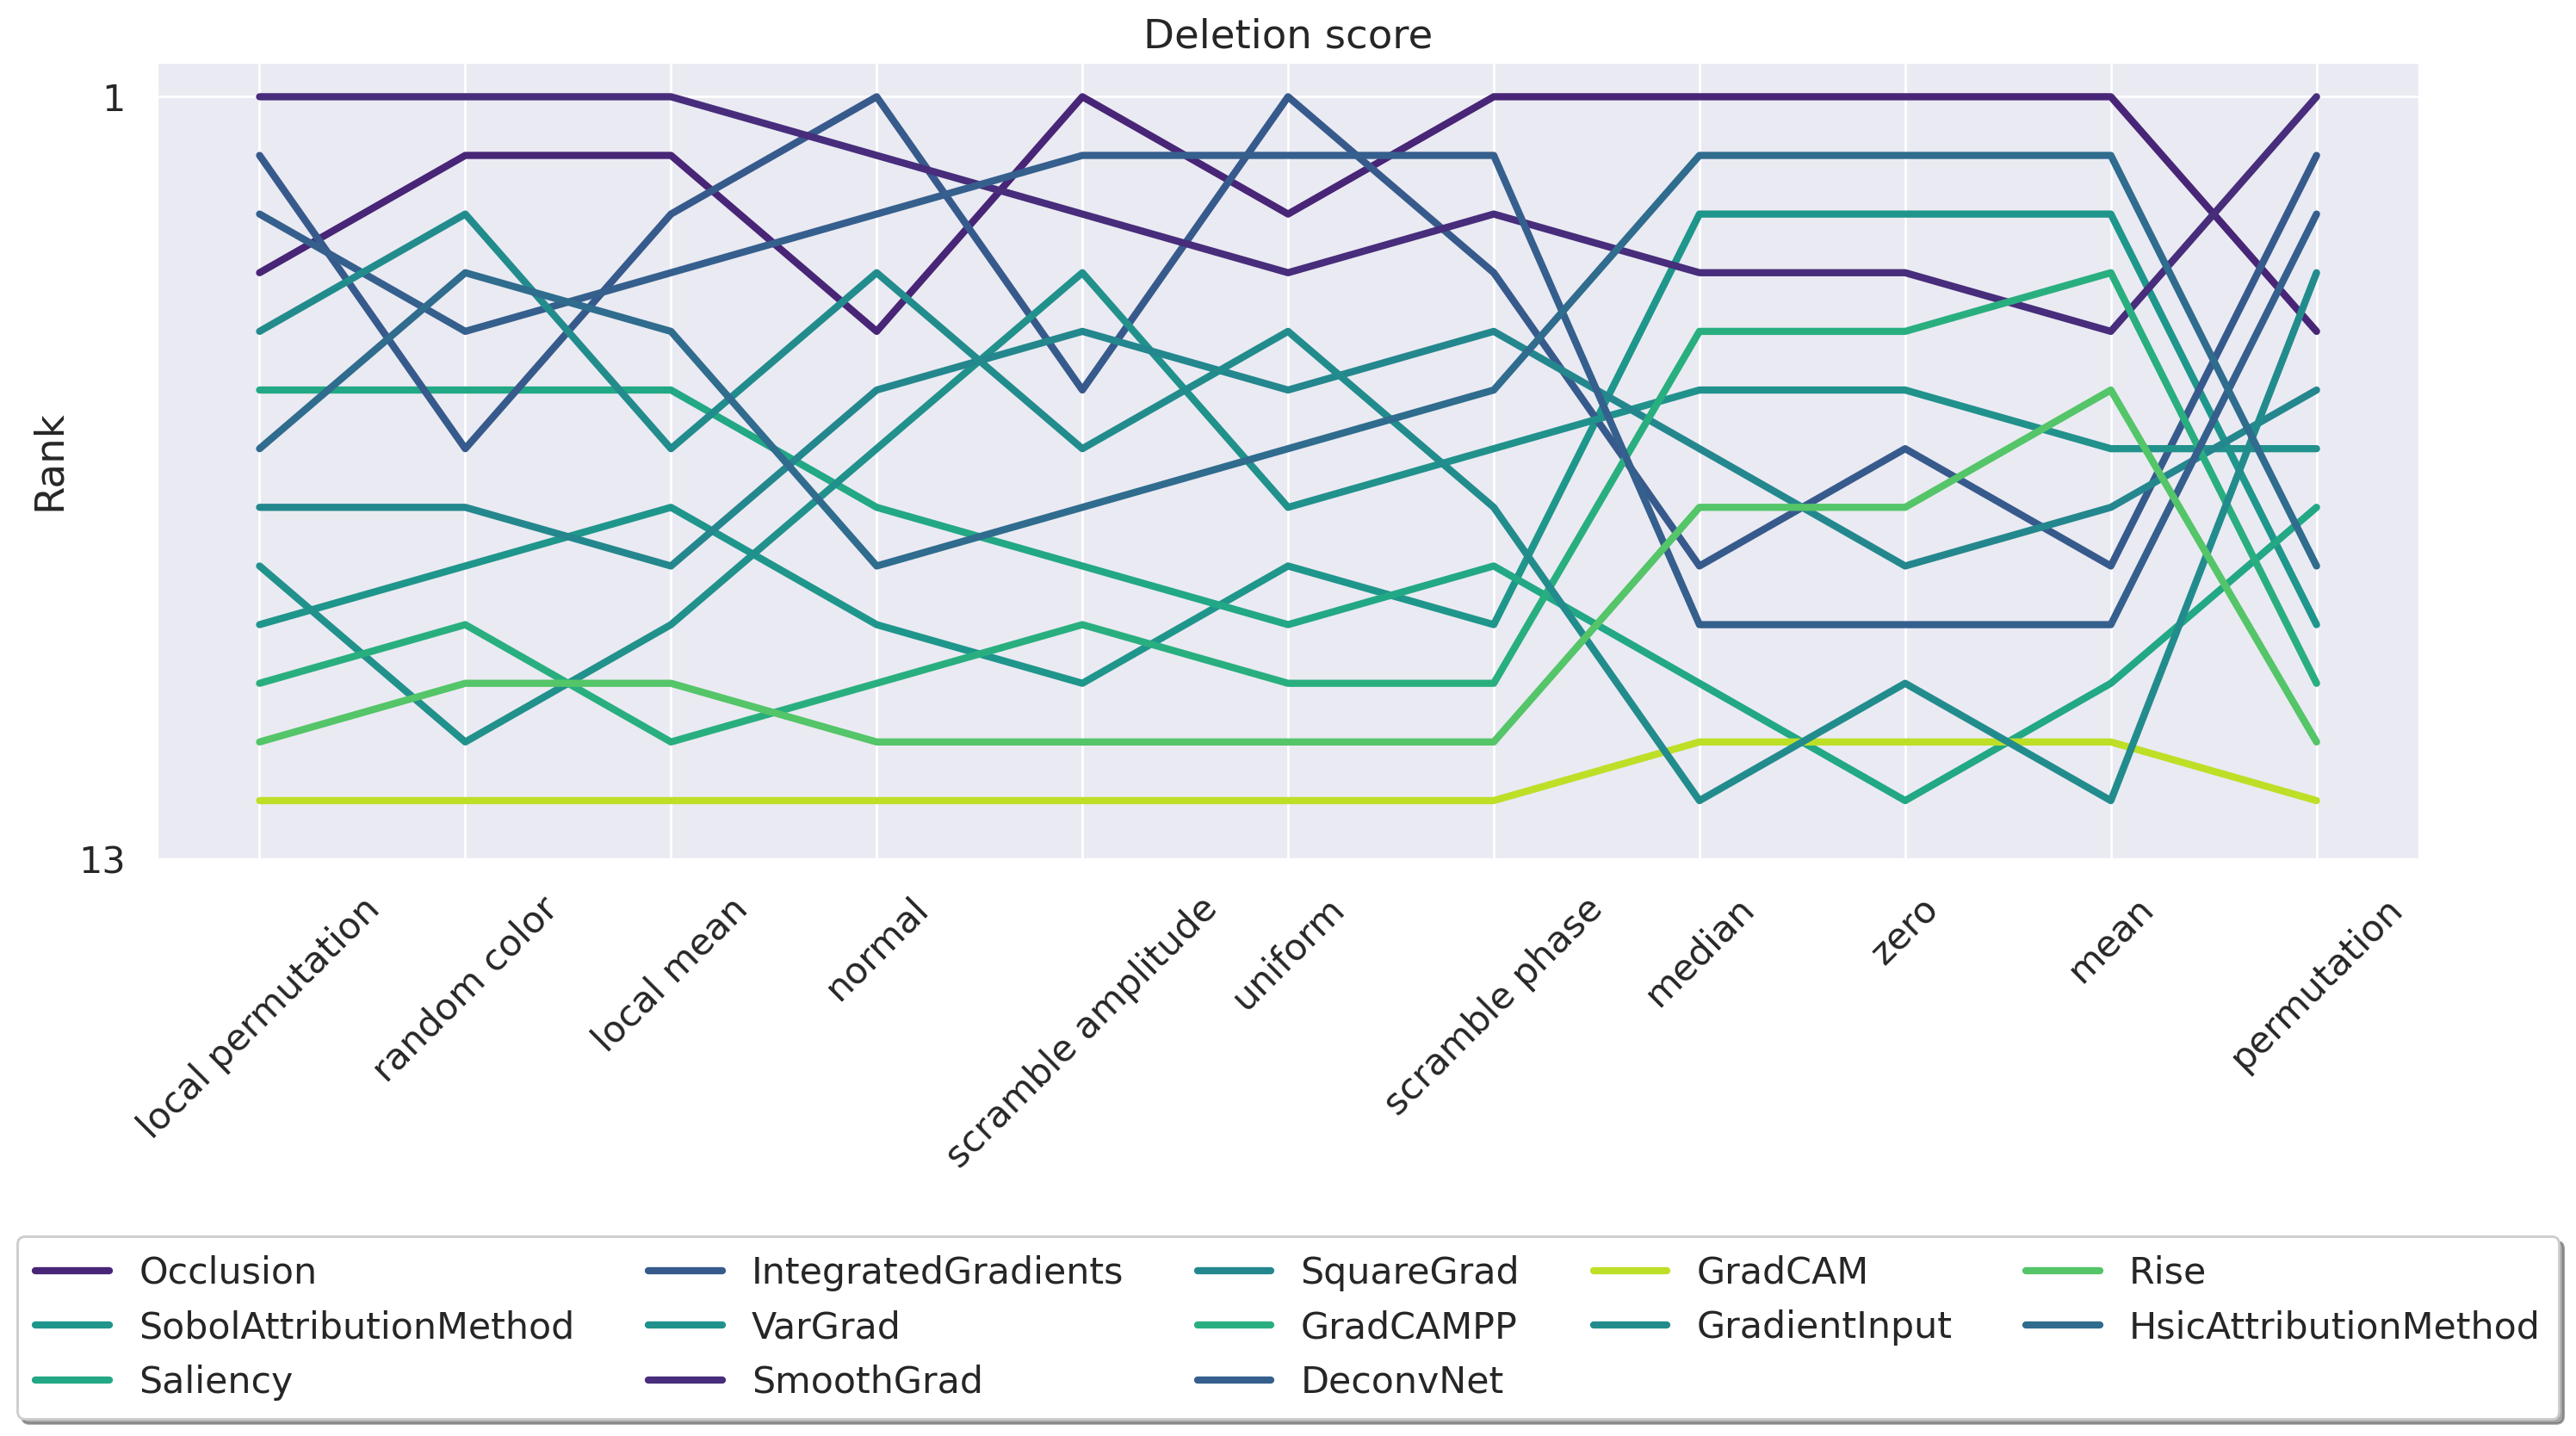

In [ ]:
sns.set(font_scale=1.4)
set_size(16, 10)
cmap = plt.get_cmap('viridis')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_del[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=5, frameon=True,
                      facecolor='white') # = ivan

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Deletion score")
plt.tight_layout()
plt.savefig('deletion_ranking.png', dpi=400, transparent=True)
plt.show()

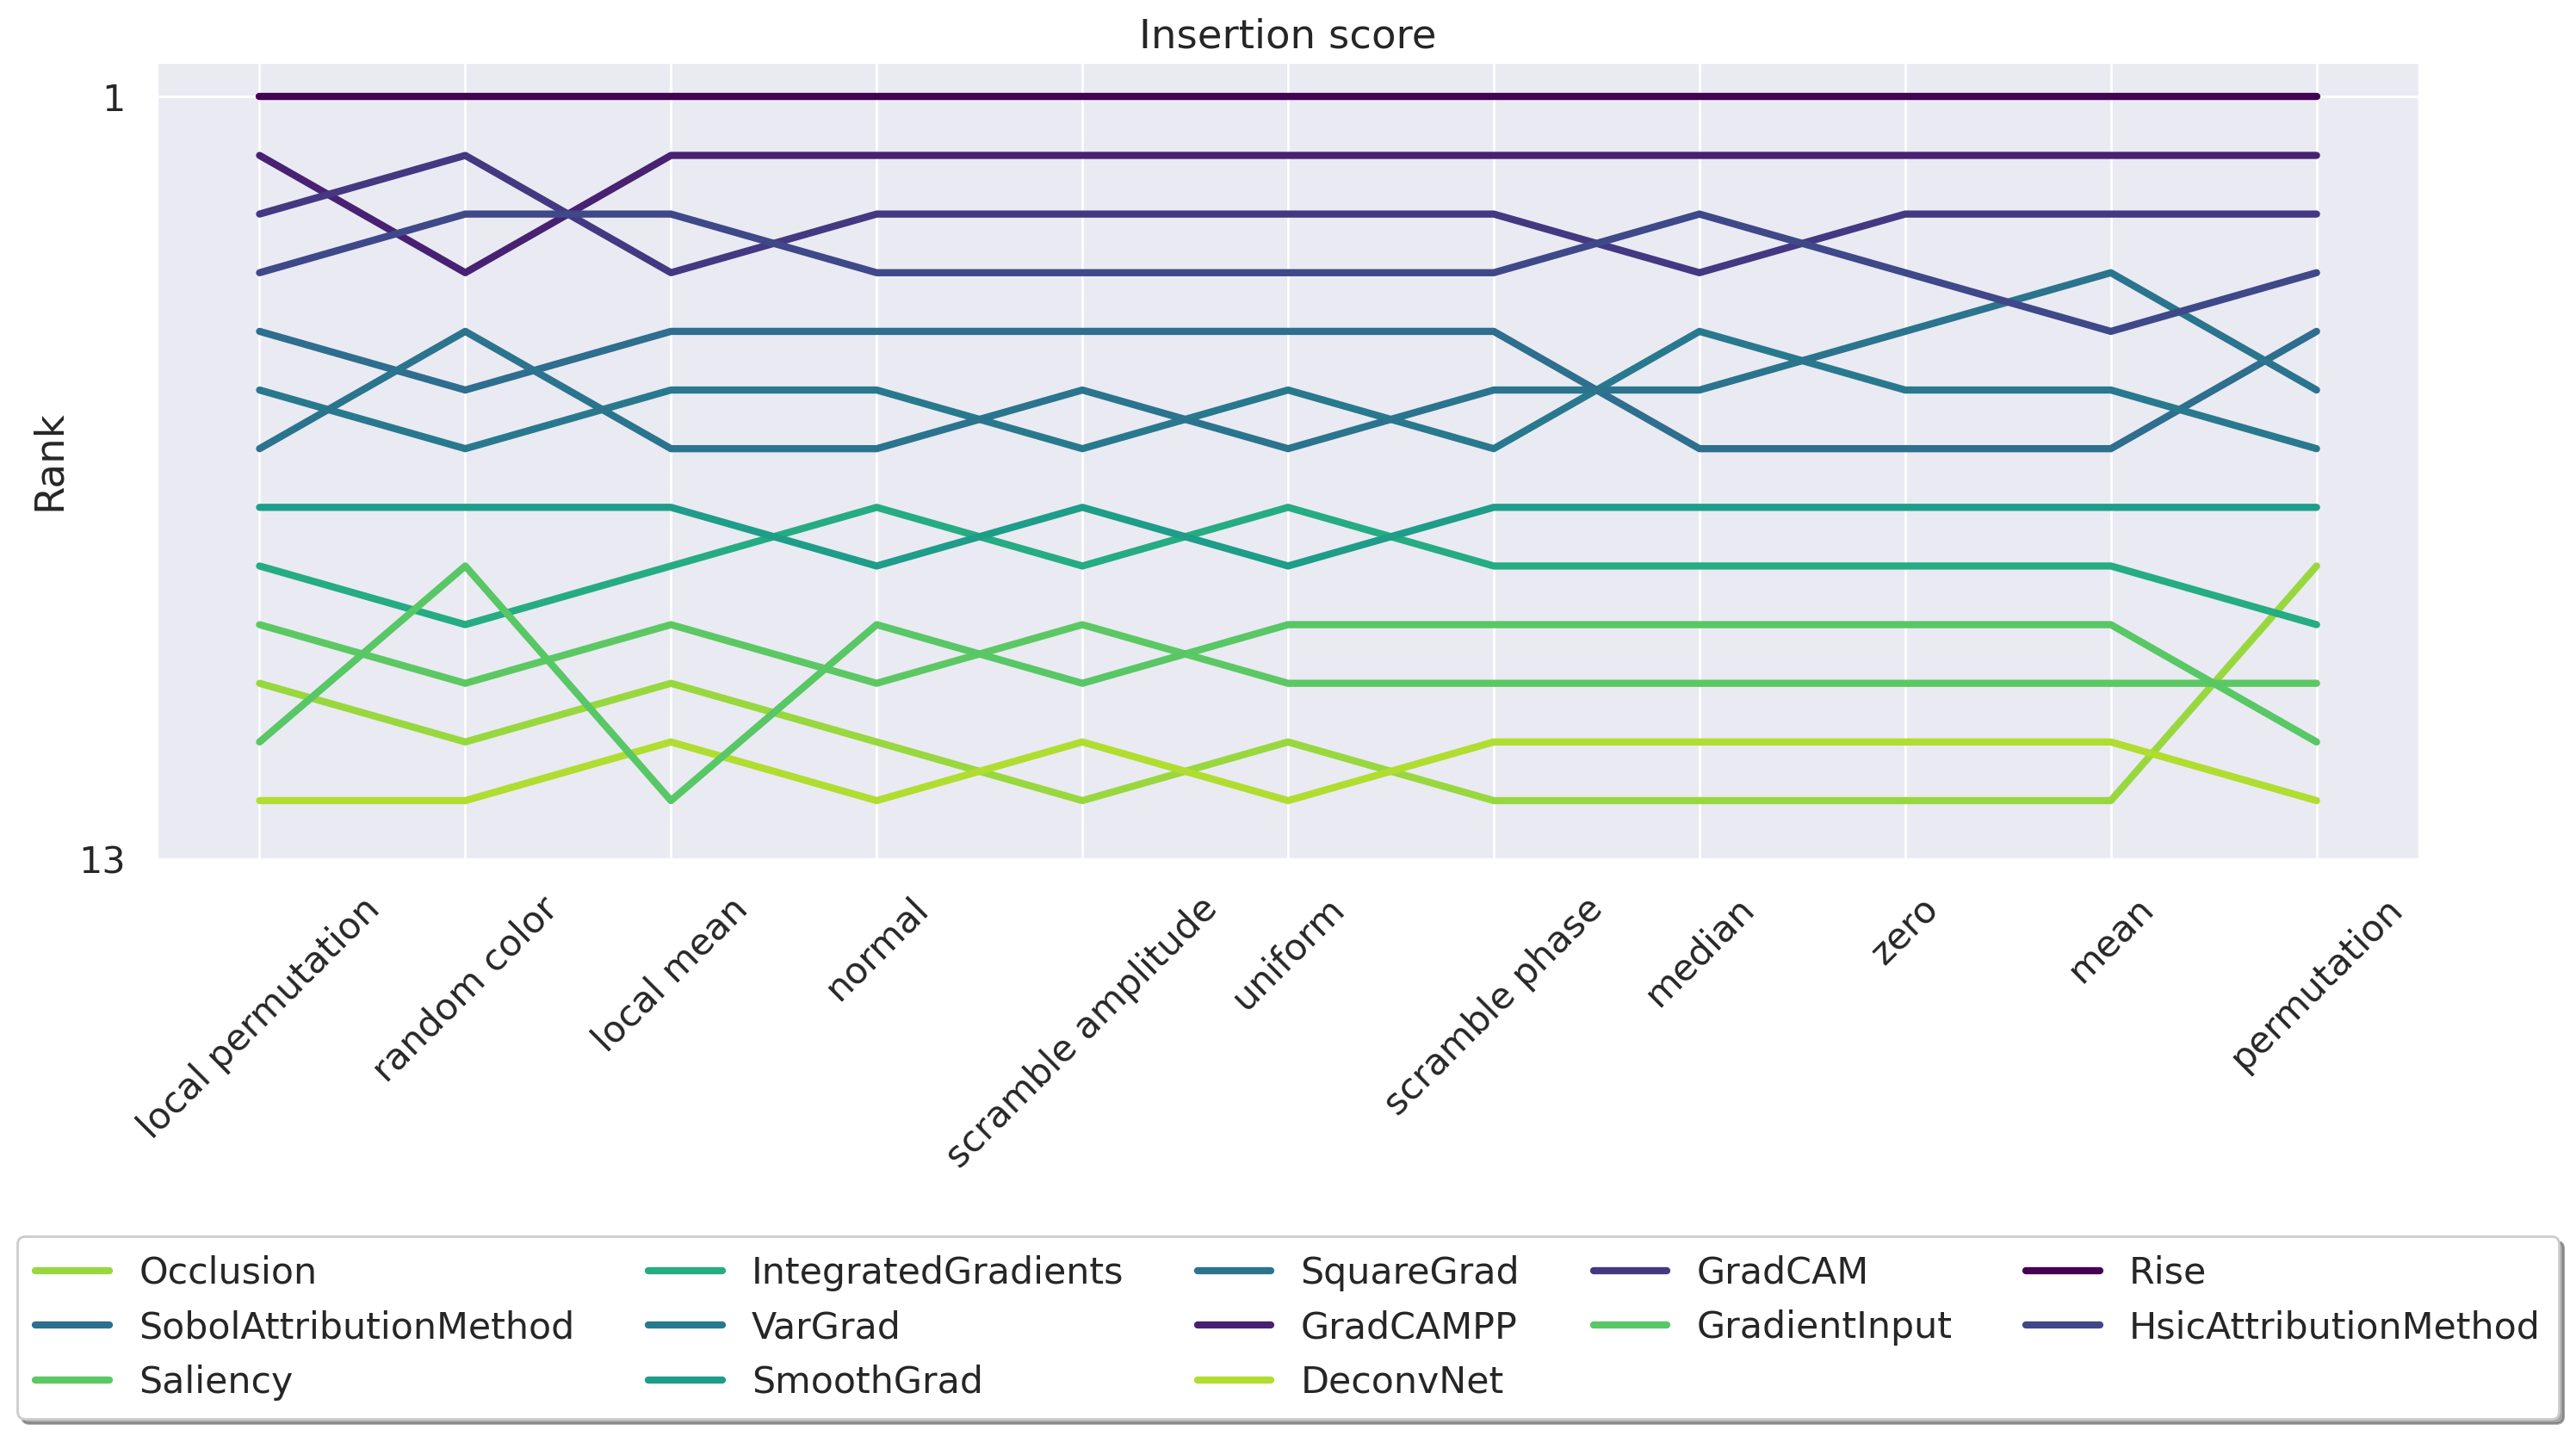

In [ ]:
sns.set(font_scale=1.4)
set_size(16, 10)
cmap = plt.get_cmap('viridis')

lw = 3.0

for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color, linewidth=lw)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=5, frameon=True,
                      facecolor='white') # = ivan

plt.xticks(range(len(baselines)), [b.replace('_', ' ') for b in baselines], rotation=45)
#plt.yticks(range(1, len(methods)+1), [len(methods) - i for i in range(len(methods))])
plt.yticks([0, len(methods)], [len(methods), 1])
plt.ylabel('Rank')
#plt.xlabel('Baselines')
plt.title("Insertion score")
plt.tight_layout()
plt.savefig('insertion_ranking.png', dpi=400, transparent=True)
plt.show()

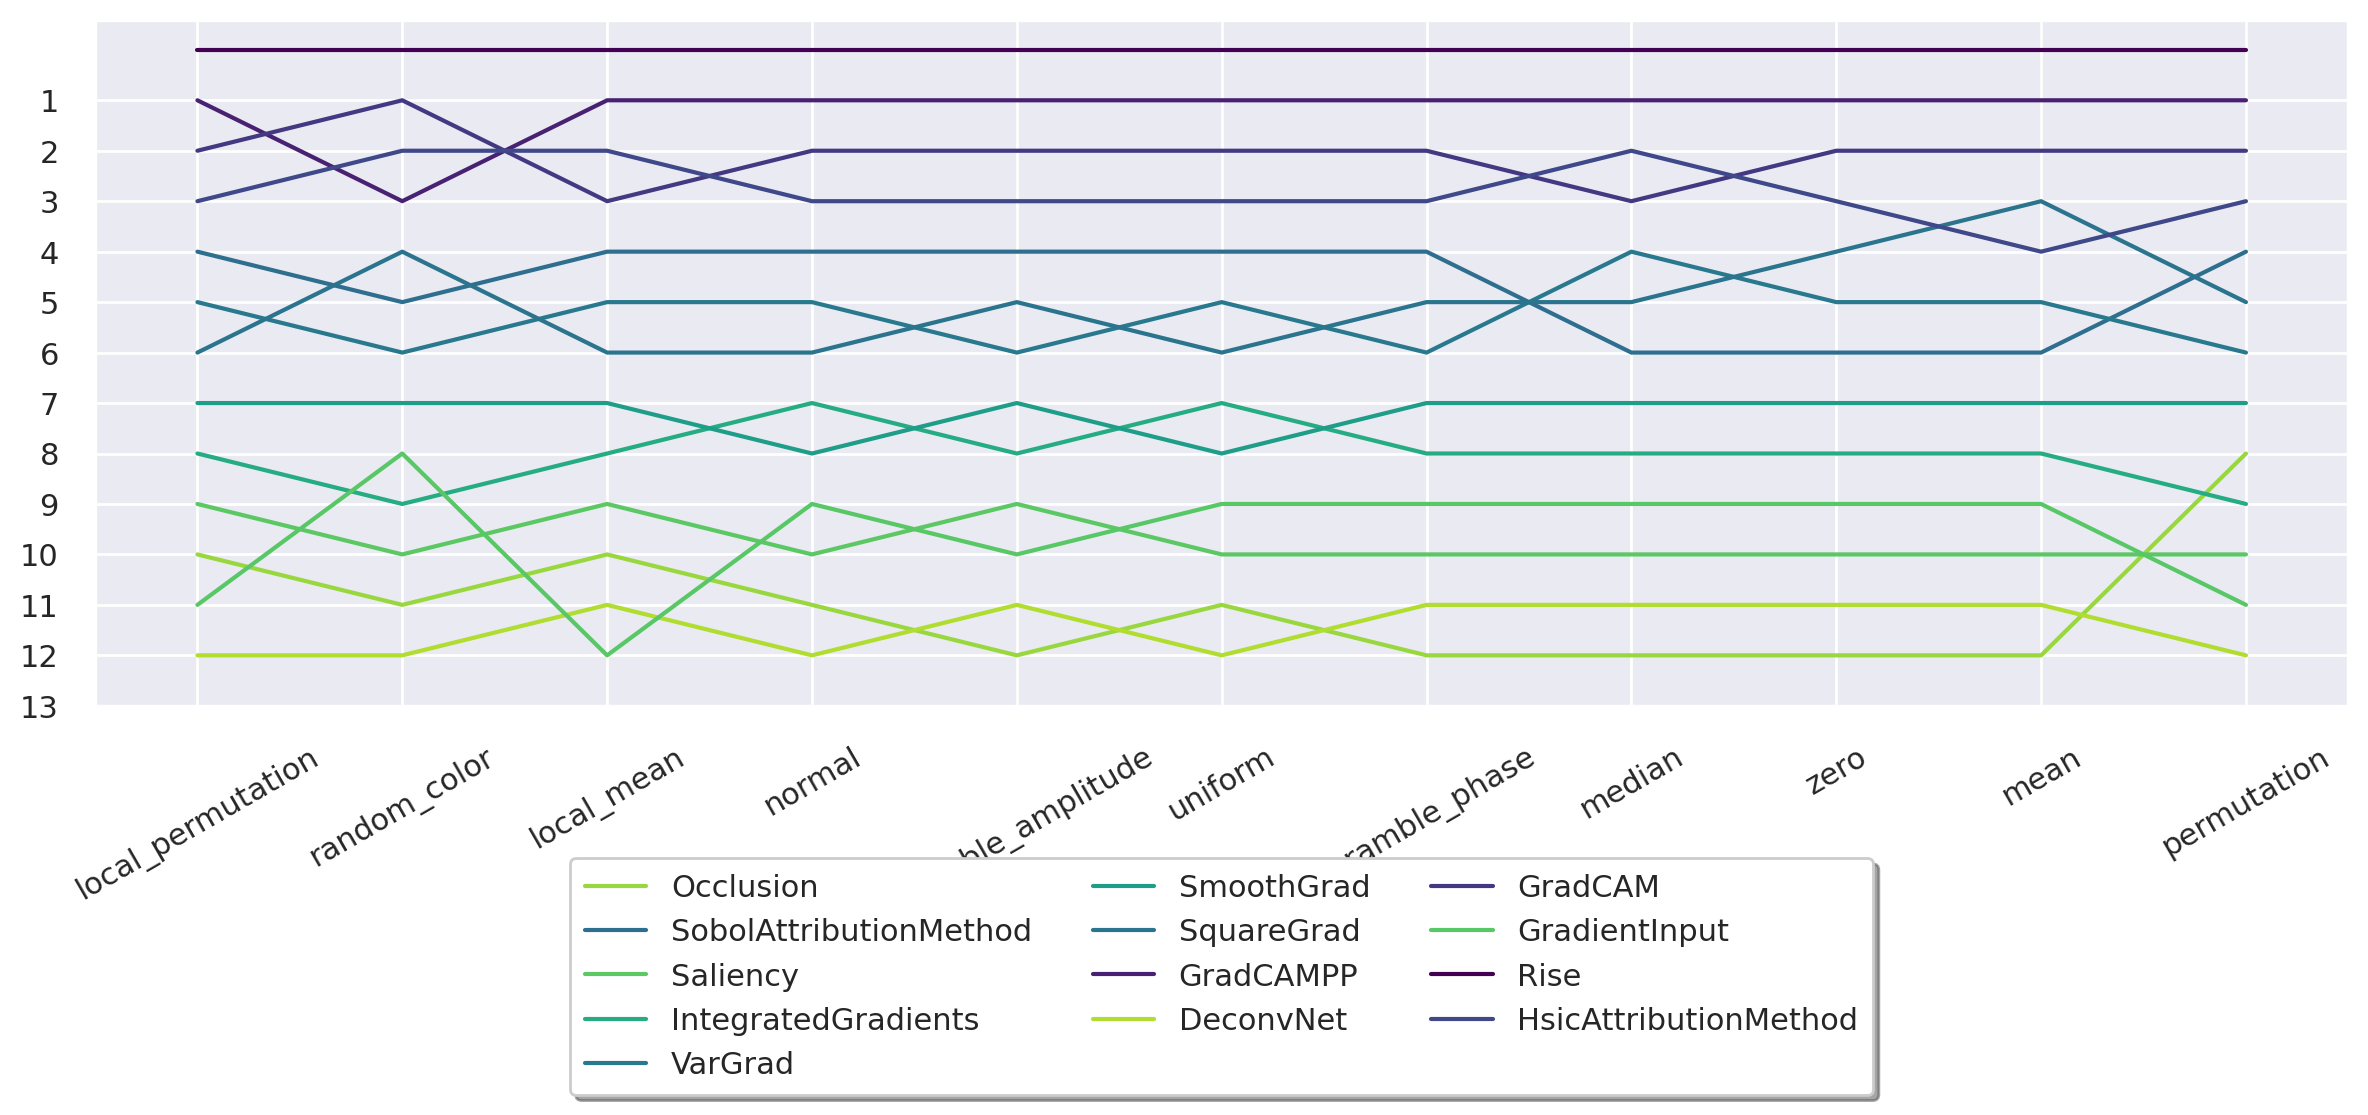

In [ ]:
sns.set(font_scale=1)
set_size(12, 6)
cmap = plt.get_cmap('viridis')


for m in methods:
  order = [len(methods) - ranks_ins[m][b] for b in baselines]
  color = cmap((len(methods) - np.mean(order)) / len(methods))
  plt.plot(order, label=m, c=color)

legend   = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2),
                      fancybox=True, shadow=True, borderpad=0.5, ncol=3, frameon=True,
                      facecolor='white') # = ivan

plt.tight_layout()
plt.xticks(range(len(baselines)), baselines, rotation=30)
plt.yticks(range(len(methods)), [len(methods) - i for i in range(len(methods))])
plt.show()